In [20]:
%matplotlib inline
import numpy as np
from math import sqrt
from numpy.linalg import norm
from scipy.optimize import line_search
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

In [76]:
### SETTINGS 
MAX_COUNT_ITER = 5000     # global
EPS = 10**(-7)            # global
DIM = 2                   # global
H = 0.0001 * np.ones(DIM) # global
freq = 200                # global

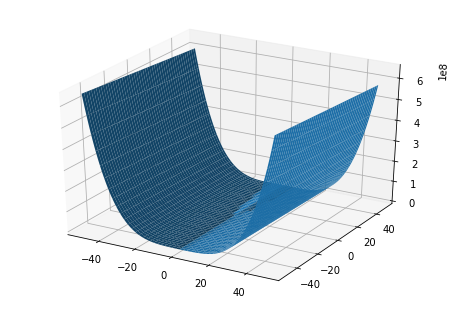

0

In [61]:
def visualize():
    x = np.arange (-50, 50, 0.5)
    y = np.arange (-50, 50, 0.5)
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = f([xgrid, ygrid])
    fig = pylab.figure()
    axes = Axes3D(fig)
    axes.plot_surface(xgrid, ygrid, zgrid)
    pylab.show()
    return 0
visualize()

In [62]:
def grad(f,x):
    if (f_type == 'q'):
        return A.dot(x)+b
    else:
        I = np.eye(DIM)
        return np.array([(f(x + H * I_vec) - f(x - H * I_vec)) / (2.0 * (H @ I_vec)) for I_vec in I])

def compute_grad(f):
    def grads(x):
        if (f_type == 'q'):
            return A.dot(x)+b
        else:
            I = np.eye(DIM)
            return np.array([(f(x + H * I_vec) - f(x - H * I_vec))
                             / (2.0 * (H @ I_vec)) for I_vec in I])
    return grads
    
def hesse(f, x):
    I = np.eye(DIM)
    return np.array([(grad(f, x + H * I_vec) - grad(f, x - H * I_vec))
                     / (2.0 * (H @ I_vec)) for I_vec in I])

### FINDING ALPHA
def alpha_quadr(f,x,step): 
    return -np.dot((A.dot(x)+b),step) / (A.dot(step) @ step)

def alpha_split(f,x,step,b=1,l=0.5,q=0.1):
    alpha = b
    #while (f(x+alpha*step) >= f(x)):
    while f(x+alpha*step) > f(x) + q * alpha * (grad(f,x) @ (step)):
        alpha *= l
    return alpha

### FINDING BETA
def beta_quadr(f,x_prev,x_next,step_prev):
    return (grad(f,x_next) @ A.dot(step_prev)) / (step_prev @ A.dot(step_prev))

def beta_non_quadr(f,x_prev,x_next,step_prev):
    return ((grad(f,x_next) @ grad(f,x_next) - grad(f,x_prev))
            / (grad(f,x_next) @ grad(f,x_next)))

### STOP CONDITIONS
def stop(f,x1,x2,k):
    return stop1(f,x1,x2,k) and stop2(f,x1,x2,k) and stop3(f,x2,k)

def stop1(f,x1,x2,k):
    d = norm(x2-x1)
    #print(d)
    plt.xlabel('iteration')
    plt.ylabel('|| x_next - x_prev || ')
    if d>EPS:
        plt.scatter(k, d)
    return d<=EPS

def stop2(f,x1,x2,k):
    d = abs(f(x2)-f(x1))
    #print(d)
    plt.xlabel('iteration')
    plt.ylabel('| f(x_next) - f(x_prev) | ')    
    if d>EPS:
        plt.scatter(k, d)
    return d<=EPS

def stop3(f,x,k):
    d = norm(grad(f,x), ord=DIM)
    #print(d)
    plt.ylabel('|| f\'(x_next) || ')
    if d>EPS:
        plt.scatter(k, d)
    return d<=EPS


### OUTPUT
def output_init(fout,x0,step):
    print('The initial point is ({x}, {y})\n'.format(x=x0[0], y=x0[1]))
    print('  k|'+' '*8+'x'+' '*9+'|'+' alpha '+ '|'+' '*7+'step'+' '*7)
    #print('{i:>3}| ({x:>6.3f}, {y:>6.3f}) |{al}| ({st_x:>6.3f}, {st_y:>6.3f}) '
    #      .format(i=0, x=x0[0], y=x0[1], al=' '*7, st_x = step[0], st_y = step[1]))
    fout.write('The initial point is ({x}, {y})\n\n'.format(x=x0[0], y=x0[1]))
    fout.write('  k|'+' '*16+'x'+' '*17+'|'+' '*5+'alpha'+' '*5+ '|'+' '*15+'step'+' '*15+'\n')
    #fout.write('{i:>3}| ({x:>14.11f}, {y:>14.11f}) |{al}|{st}\n'.format(i=0, x=x0[0], y=x0[1], al=' '*15, st=' '*34))
    pass

def print_inter(fout,k,alpha,x,step):
    print('{i:>3}| ({x:>6.3f}, {y:>6.3f}) | {al:<5.3f} | ({st_x:>6.3f}, {st_y:>6.3f}) '
          .format(i=k, x=x[0], y=x[1], al=alpha, st_x = step[0], st_y = step[1]))
    pass

def output_inter(fout,k,alpha,x,step):
    fout.write('{i:>3}| ({x:>14.11f}, {y:>14.11f}) | {al:<13.11f} | '
               '({st_x:>14.11f}, {st_y:>14.11f}) \n'.format(i=k, x=x[0], y=x[1], al=alpha, 
                                                            st_x = step[0], st_y = step[1]))
    pass

def output_result(fout,k,x):
    #print('{i:>3}| ({x:>6.3f}, {y:>6.3f}) |{al}| '.format(i=k+1, x=x[0], y=x[1], al=' '*7))
    print('\nTOTAL ITERATIONS: {}'.format(k))
    print('SOLUTION: x    = ({x:>10.7f}, {y:>10.7f})'.format(x=x[0], y=x[1]))
    print('VALUE:    f(x) =  {v:>10.7f}\n'.format(v=f(x)))
    #fout.write('{i:>3}| ({x:>14.11f}, {y:>14.11f}) |{al}|\n'.format(i=k+1, x=x[0], y=x[1], al=' '*15))
    fout.write('\nTOTAL ITERATIONS: {}\n'.format(k))
    fout.write('SOLUTION: x    = ({x:>10.7f}, {y:>10.7f})\n'.format(x=x[0],  y=x[1]))
    fout.write('VALUE:    f(x) =  {v:>10.7f}\n'.format(v=f(x)))
    pass

# Метод спряжених напрямів першого порядку

In [77]:
def conjugate_directions(f,x0):
    fout = open('output.txt', 'w')
    k = -1
    x_next = x0
    step_next = - grad(f,x_next)
    flag = True
    output_init(fout,x0,step_next)
    find_beta = beta_quadr if f_type == 'q' else beta_non_quadr
    find_alpha = alpha_quadr if f_type == 'q' else alpha_split
    while (k < MAX_COUNT_ITER):
        x_prev = x_next  
        step_prev = step_next

        #grad_f = compute_grad(f)        
        #old_fval = f(x_prev)
        #alpha =  line_search(f, grad_f, x_prev, step_prev, old_fval=old_fval)[0]
        #print(line_search(f, grad_f, x_prev, step_prev, old_fval=old_fval))
        alpha = find_alpha(f,x_prev,step_prev)
        x_next = x_prev + alpha * step_prev
        
        if (f_type != 'q') and (k // freq == 0):
            beta = 0
        else:
            beta = find_beta(f,x_prev,x_next,step_prev)
        step_next = - grad(f,x_next) + beta * step_prev

        k += 1
        if k < 20:
            print_inter(fout,k,alpha,x_prev,step_prev)
        else:
            if flag == True:
                print('...')
                flag = False
        output_inter(fout,k,alpha,x_prev,step_prev)
        #output_inter(fout,k,alpha,x_next,step_next)
        if stop(f,x_prev,x_next,k) or (alpha < EPS ):
            break
    output_result(fout,k,x_next)
    fout.close()
    return x_next

The initial point is (0.0, 0.0)

  k|        x         | alpha |       step       
  0| ( 0.000,  0.000) | 0.062 | ( 2.000, -0.000) 
  1| ( 0.125,  0.000) | 0.016 | ( 3.342,  3.125) 
  2| ( 0.177,  0.049) | 0.008 | ( 2.880, -3.484) 
  3| ( 0.200,  0.022) | 0.008 | ( 0.140,  3.656) 
  4| ( 0.201,  0.050) | 0.008 | ( 2.389, -1.969) 
  5| ( 0.219,  0.035) | 0.008 | ( 0.386,  2.677) 
  6| ( 0.223,  0.056) | 0.008 | ( 2.106, -1.239) 
  7| ( 0.239,  0.046) | 0.008 | ( 0.463,  2.216) 
  8| ( 0.243,  0.063) | 0.008 | ( 1.950, -0.898) 
  9| ( 0.258,  0.056) | 0.008 | ( 0.438,  2.030) 
 10| ( 0.261,  0.072) | 0.008 | ( 1.889, -0.787) 
 11| ( 0.276,  0.066) | 0.008 | ( 0.329,  2.028) 
 12| ( 0.279,  0.082) | 0.008 | ( 1.920, -0.856) 
 13| ( 0.294,  0.075) | 0.008 | ( 0.123,  2.198) 
 14| ( 0.295,  0.092) | 0.008 | ( 2.073, -1.124) 
 15| ( 0.311,  0.084) | 0.008 | (-0.232,  2.592) 
 16| ( 0.309,  0.104) | 0.004 | ( 2.422, -1.683) 
 17| ( 0.318,  0.097) | 0.500 | ( 0.842,  0.819) 
 18| ( 0.739,  0.

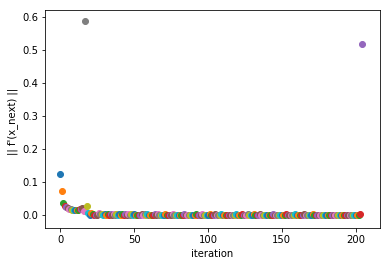

In [78]:
x0 = np.array([0, 0], dtype = float)
f_type = 'n'
if (f_type == 'q'):
    #A = np.array([[8, 0], [0, 2]], dtype = float)
    #b = np.array([0, 0], dtype = float)
    A = np.array([[2, 0.001], [0.001, 8]], dtype = float)
    b = np.array([0, -1], dtype = float)
    def f(x):
        a1 = 1/2 * A[0,0]
        a12 = A[0,1]
        a2 = 1/2 * A[1,1]
        return a1 * x[0] ** 2 + a12 * x[0] * x[1] + a2 * x[1] ** 2 + b[0] * x[0] + b[1] * x[1]
else:
    f = f_test1
    
minim = conjugate_directions(f,x0)
plt.xlabel('iteration')
plt.show()
print()

In [70]:
### TARGET FUNCTIONS 

def f_test1(x):
    # The true solution of the problem is (1, 0)
    # The value of function in this point is 0
    return x[0]**4 + x[1]**4 + 2 * x[0]**2 * x[1]**2 - 4 * x[0] + 3

def f_test2(x):
    # The true solution of the problem is (2.39395,2.39395)
    # The value of function in this point is 5.10682
    return (x[0]**2 + x[1]**2 - 11)**2 +(x[0] + x[1] - 7)**2

def f_test3(x):
    # The true solution of the problem is (5, 3)
    # The value of function in this point is 0
    return 4 * (x[0] - 5)**2 + (2 * x[1] - 6)**2

def f_test4(x):
    # The true solution of the problem is (1, 1)
    # The value of function in this point is -1
    return x[0]**3 + x[1]**2 - 3 * x[0] - 2 * x[1] + 2

def f_myvar(x):  
    # The true solution of the problem is (-0.0000625,  0.1250000)
    # The value of function in this point is  2.5626251
    return x[0]**2 + 4.0 * x[1]**2 + 0.001 * x[0] * x[1] - x[1]  

#def f_Rosenbrock(x):
    # The true solution of the problem is (1, 1)
    # The value of function in this point is 0
    #return 100.0 * (x[1] - x[0]**2)**2 + (1.0 - x[0])**2 

